Goal of this is to analyze sounds and crop out the non-specific sounds we want. Sometimes it's hard to ONLY record the data you want, so a lot of prep for DL goes into making sure you tag things correctly

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
from IPython.display import Audio
import os

#jupyternote, must install via conda, not pip3
#for audio visualization
import librosa
import librosa.display

#for editing wav files
from pydub.silence import detect_nonsilent
from pydub import AudioSegment
from pydub.silence import split_on_silence


Okay, let's hear what we have

In [8]:
Audio('data/snooze.1cn957t8.wav')

Nice, let's see what the looks like, I found this handy library for audio in python here:
https://github.com/librosa/librosa

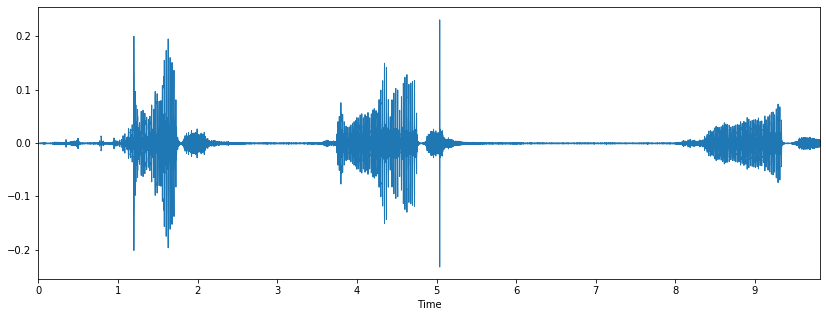

In [9]:
#librosa things from https://musicinformationretrieval.com/ipython_audio.html

signal, samplingrate = librosa.load("data/snooze.1cn957t8.wav")
plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr=samplingrate)

There is a way to do it without importing a new library and just by using matplotlib. That's below. I think the above looks prettier. Plus, it has some other features for editing that will make things easier later.

/Users/karfez01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/Users/karfez01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


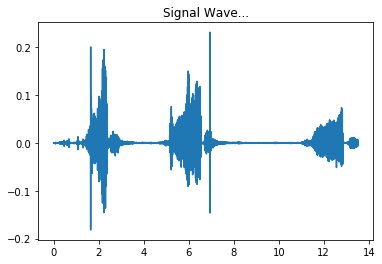

In [10]:
#the Python Way
spf = wave.open("data/snooze.1cn957t8.wav", "r")

# Extract Raw Audio from Wav File
rawsignal = spf.readframes(-1)
rawsignal = np.fromstring(rawsignal, "Int16")
fs = spf.getframerate()

# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)


Time = np.linspace(0, len(signal) / fs, num=len(signal))

plt.figure(1)
plt.title("Signal Wave...")
plt.plot(Time, signal)
plt.show()

To look at that on a spectral analysis, we can see a bit clearer where our highs and lows are

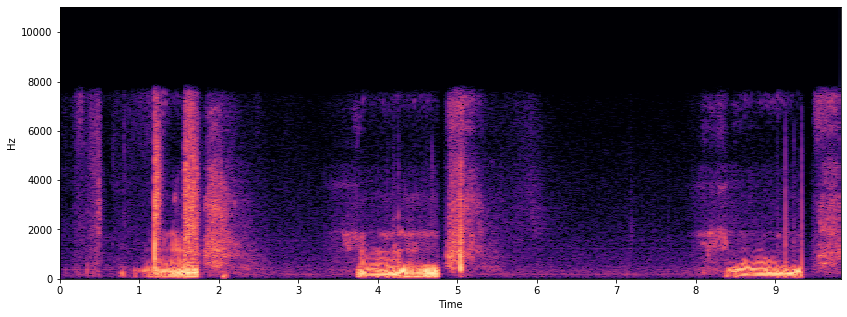

In [15]:
sr=samplingrate
fouriertrans = librosa.stft(signal)
fourierdb = librosa.amplitude_to_db(abs(fouriertrans))
plt.figure(figsize=(14, 5))
librosa.display.specshow(fourierdb, sr=samplingrate, x_axis='time', y_axis='hz')

Let's here again what that sounds like

In [13]:
Audio('data/snooze.1cn957t8.wav')

Let's look at the log to see a bit more detail and also see the DB.

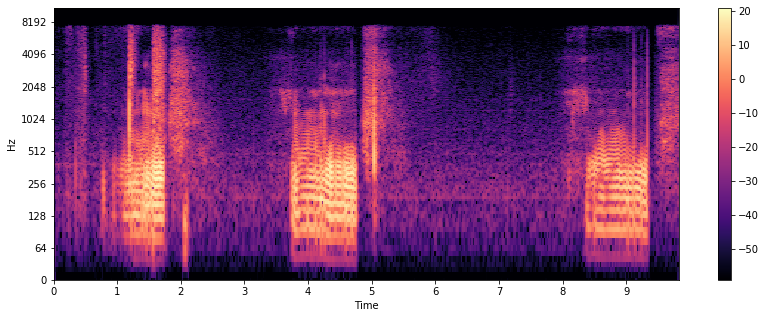

In [16]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(fourierdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [17]:
print(fourierdb.shape)

(1025, 423)


In [18]:
loudspikes = np.argwhere(fourierdb > 0)
print(loudspikes)

[[  7  67]
 [  7  68]
 [  7  69]
 ...
 [329  52]
 [366  72]
 [414  68]]


In [19]:
editeddb= fourierdb[fourierdb > 0]
print(editeddb)

[1.8488412  2.061915   0.0117028  ... 1.1192805  0.04480552 0.22697411]


Now to edit out those lows, basically everything below 128HZ we want to crop out
Tried Pydub, but didn't work, only good for silence

In [20]:
sound = AudioSegment.from_file("data/snooze.1cn957t8.wav", format="wav")
sound.dBFS

-39.9387199016366

In [57]:
silence_threshold =-70
detect_nonsilent(sound, silence_thresh=silence_threshold)

[[0, 378], [1996, 4928], [7841, 11183], [12768, 14206], [17298, 18130]]

In [35]:

chunks = split_on_silence(
    sound,

    # split on silences longer than 1000ms (1 sec)
    min_silence_len=500,

    # anything under -70 dBFS is considered silence
    silence_thresh=silence_threshold, 

    # keep 0 ms of leading/trailing silence
    keep_silence=0
)

print (len(chunks))


3


In [36]:
j = 0
for i in chunks:
    j+=1
    print(j)
    name = "edited" + str(j) + ".wav"
    i.export(name, format="wav")

1
2
3


In [37]:
Audio('edited1.wav')

In [38]:
Audio('edited2.wav')

In [39]:
Audio('edited3.wav')

In [40]:
newsound = chunks[0]
for piece in chunks[1:]:
    newsound += piece
newsound.export("croppedandcombined.wav", format="wav")
Audio("croppedandcombined.wav")

Time to do it costco-style (in bulk):

In [43]:
data_path = 'data'
cleaned_data_path = 'edited_samples'
root_path= os.getcwd()

Bulk Clip Audio Files in right paths

In [58]:
for file in os.listdir(data_path):
    if file.endswith(".wav"):
        print(file)
        sound = AudioSegment.from_file(data_path+"/"+file, format="wav")
        chunks = split_on_silence(sound,min_silence_len=500,silence_thresh=silence_threshold,keep_silence=0)
        newsound = chunks[0]
        for piece in chunks[1:]:
            newsound += piece
            newsound.export(cleaned_data_path+"/"+"trimmed_"+file, format="wav")
      

snooze.1cn9d73h.wav
snooze.1cn9sqn5.wav
snooze.1cn978kg.wav
snooze.1cn957t8.wav
snooze.1cn980ja.wav
snooze.1d17oks3.wav
snooze.1cn9aqcp.wav
snooze.1cn98hla.wav
snooze.1d17mv2p.wav
snooze.1cn9bsod.wav
snooze.1d17rdgj.wav
snooze.1d17ptvm.wav
snooze.1d17svpt.wav
snooze.1cn9ed5a.wav
snooze.1cn99lch.wav
snooze.1co4tb68.wav
snooze.1cn969rd.wav


In [60]:
Audio('data/snooze.1cn9bsod.wav')

Now time to export up to Edge Impulse via their handy CLI: Make sure you install it. 
https://docs.edgeimpulse.com/docs/cli-uploader
Feel free to copy this cell and run in a console, just remove the "!"
Note: Try it from a Console first to login if you have not configged the Edge Impulse CLI Yet

In [66]:
!edge-impulse-uploader --label snooze edited_samples/*.wav

Edge Impulse uploader v1.7.3
Endpoints:
    API:         https://studio.edgeimpulse.com/v1
    Ingestion:   https://ingestion.edgeimpulse.com

Upload configuration:
    Label:       snooze
    Category:    training
    Project:     Porksnoozes (ID: 4466)

[ 1/20] Uploading edited_samples/edited3.wav OK (2765 ms)
[ 2/20] Uploading edited_samples/edited1.wav OK (3325 ms)
[ 3/20] Uploading edited_samples/trimmed_snooze.1cn98hla.wav OK (3543 ms)
[ 4/20] Uploading edited_samples/trimmed_snooze.1cn9bsod.wav OK (3933 ms)
[ 5/20] Uploading edited_samples/trimmed_snooze.1cn9ed5a.wav OK (3724 ms)
[ 6/20] Uploading edited_samples/trimmed_snooze.1cn980ja.wav OK (4240 ms)
[ 7/20] Uploading edited_samples/edited2.wav OK (4627 ms)
[ 8/20] Uploading edited_samples/trimmed_snooze.1cn9aqcp.wav OK (4711 ms)
[ 9/20] Uploading edited_samples/trimmed_snooze.1d17mv2p.wav OK (5849 ms)
[10/20] Uploading edited_samples/trimmed_snooze.1cn99lch.wav OK (5626 ms)
[11/20] Uploading edited_samples/trimmed_snooze.1d17

Thanks Librosa!

https://zenodo.org/record/3606573#.Xw80J5NKjUI


Other important sources:
https://docs.python.org/3/library/wave.html
https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
https://musicinformationretrieval.com/stft.html
https://github.com/jiaaro/pydub
        